# Machine learning con Python.
#### Febrero 2021.
##### Jaime Sánchez Bermejo.

### 1. Cargar los datasets y construir un único tablón analítico con todas las variables que consideremos necesarias para cada una de las cosechas que queremos analizar.
### 
##### En este apartado se cargarán y unirán los datasets correspondientes a diciembre y a enero por separado. Las labores de imputaciones de valores nulos o outliers, además de otras cuestiones de preprocesamiento y limpieza de datos se realizarán en apartados posteriores.

#### 1.1 Construcción de tablones

In [268]:
# Carga de librerías (posteriormente se irán cargando las librerías necesarias. Estas para comenzar)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [269]:
###### Carga de tablas de diciembre y enero
# Diciembre:
clientes_diciembre = pd.read_csv('C:/Users/jaime/OneDrive/Escritorio/Máster Big Data & Data Science UCM\Machine Learning/Python/Tarea/diciembre/clientes_diciembre.csv', sep = '|')
consumos_diciembre = pd.read_csv('C:/Users/jaime/OneDrive/Escritorio/Máster Big Data & Data Science UCM\Machine Learning/Python/Tarea/diciembre/consumos_diciembre.csv', sep = '|')
financiacion_diciembre = pd.read_csv('C:/Users/jaime/OneDrive/Escritorio/Máster Big Data & Data Science UCM\Machine Learning/Python/Tarea/diciembre/financiacion_diciembre.csv', sep = '|')
productos_diciembre = pd.read_csv('C:/Users/jaime/OneDrive/Escritorio/Máster Big Data & Data Science UCM\Machine Learning/Python/Tarea/diciembre/productos_diciembre.csv', sep = '|')

# Enero:
clientes_enero = pd.read_csv('C:/Users/jaime/OneDrive/Escritorio/Máster Big Data & Data Science UCM\Machine Learning/Python/Tarea/enero/clientes_enero.csv', sep = '|')
consumos_enero = pd.read_csv('C:/Users/jaime/OneDrive/Escritorio/Máster Big Data & Data Science UCM\Machine Learning/Python/Tarea/enero/consumos_enero.csv', sep = '|')
financiacion_enero = pd.read_csv('C:/Users/jaime/OneDrive/Escritorio/Máster Big Data & Data Science UCM\Machine Learning/Python/Tarea/enero/financiacion_enero.csv', sep = '|')
productos_enero = pd.read_csv('C:/Users/jaime/OneDrive/Escritorio/Máster Big Data & Data Science UCM\Machine Learning/Python/Tarea/enero/productos_enero.csv', sep = '|')

In [270]:
######  Comprobar si las tablas se pueden concatenar mediante sus id (deben ser idénticos o 
######  estar contenidos en el caso de financiación):
clientes_diciembre.shape # <- (95467, 8)
consumos_diciembre.shape # <- (95467, 6)
financiacion_diciembre.shape # <- (24198, 4)
productos_diciembre.shape # <- (95467, 4)

# Los id de clientes_diciembre y consumos_diciembre coinciden:
sum(clientes_diciembre['id'] == consumos_diciembre['id']) # <- 95467

# Los id de clientes_diciembre y productos_diciembre coinciden:
sum(clientes_diciembre['id'] == productos_diciembre['id']) # <- 95467

# Los id de financiación_diciembre están dentro de clientes_diciembre, y, por lo tanto, de las demás tablas:
sum(financiacion_diciembre['id'].isin(clientes_diciembre['id'])) # <- 24198

24198

In [271]:
###### Concateno tablas de diciembre mediante la función merge:
# Primero clientes con consumos (la llamo union_diciembre):
union_diciembre = clientes_diciembre.merge(consumos_diciembre, on='id') 

# Ahora union_diciembre con financiacion_diciembre. Al tener financiacion_diciembre menos registros
# por lo comentado previamente, se realizará mediante un left join para que los registros que no crucen
# se queden como NaN.
union_diciembre = union_diciembre.merge(financiacion_diciembre, how = 'left', on='id') 

# Por último, union_diciembre con productos_diciembre:
union_diciembre = union_diciembre.merge(productos_diciembre, on='id')

# Compruebo las dimensiones de la tabla resultante (union_diciembre). Debería tener 19 columnas y 95467 filas.
union_diciembre.shape # (95467, 19)

(95467, 19)

In [272]:
###### Mismo proceso para los datasets de enero:
######  Comprobar si las tablas se pueden concatenar mediante sus id (deben ser idénticos o estar contenidos en el caso de financiacion):
clientes_enero.shape # <- (92711, 8)
consumos_enero.shape # <- (92711, 6)
financiacion_enero.shape # <- (25332, 4)
productos_enero.shape # <- (92711, 4)

# Los id de clientes_enero y consumos_enero coinciden:
sum(clientes_enero['id'] == consumos_enero['id']) # <- 92711

# Los id de clientes_enero y productos_enero coinciden:
sum(clientes_enero['id'] == productos_enero['id']) # <- 92711

# Los id de financiacion_enero están dentro de clientes_enero, y, por lo tanto, de las demás tablas:
sum(financiacion_enero['id'].isin(clientes_enero['id'])) # <- 25332

25332

In [273]:
###### Concateno tablas de enero mediante el merge:
# Primero clientes con consumos (la llamo union_enero):
union_enero = clientes_enero.merge(consumos_enero, on='id') 

# Ahora union_enero con financiacion_enero con left:
union_enero = union_enero.merge(financiacion_enero, how = 'left', on='id') 

# Por último, union_diciembre con productos_enero:
union_enero = union_enero.merge(productos_enero, on='id')

# Compruebo las dimensiones de la tabla resultante (union_enero). Debería tener 19 columnas y 92711 filas.
union_enero.shape # (92711, 19)

(92711, 19)

#### 1.2 Creación de la target
##### La variable target tiene que recoger si un cliente se ha ido de la compañía o no. Primero hay que ver cuántos clientes se han ido de diciembre a enero.

In [274]:
union_diciembre.shape # (95467, 19)
union_enero.shape # (92711, 19)

# Los clientes que se han ido de diciembre a enero los voy a calcular a través de la variable ID.
# Los ID que sí aparezcan en diciembre pero no en enero significará que se habrán ido. También habrá
# ID en enero que no estarán en diciembre porque serán nuevos clientes,

# La target significará si abandonan la compañía (False = No), (True = Sí)
target_bool = ~union_diciembre.id.isin(union_enero.id)

# Lo paso a int para tener 0 y 1 donde 0 es que sigue en la compañía y 1 es que la ha abandonado.
target = list(map(int, target_bool)) 

# Compruebo cuántas personas se habrían ido de la empresa sumando los 1 de la lista anterior
sum(target) # 7085

# Añado la target a union_diciembre. Le pongo el nombre de 'abandona'
abandona = pd.DataFrame(target.copy())

union_diciembre = union_diciembre.join(abandona)
union_diciembre = union_diciembre.rename(columns = {0:"abandona"})

### 2. Realizar un pre procesado y una limpieza de los datos, siguiendo la metodología vista en clase.

In [275]:
# Previamente a la realización del preprocesado, pongo los nombres de las variables de union_diciembre
# y union_enero en minúsculas.
union_diciembre.columns = union_diciembre.columns.str.lower() # Para union_diciembre
union_enero.columns = union_enero.columns.str.lower() # Para union_enero

#### 2.1 Tratamiento de valores nulos

##### Con el objetivo de hacerlo de forma más ordenada y para que quede más claro, para el análisis de los valores nulos se utilizarán las tablas de origen, es decir, las tablas que conforman union_diciembre. Los cambios o imputaciones de los valores nulos se realizarán en la tabla union_diciembre directamente, ya construida previamente.

##### Para union_diciembre:

In [276]:
# Inspección de los valores nulos en las tablas que conforman union_diciembre.

# Análisis de nulos en tabla clientes_diciembre
clientes_diciembre.isnull().sum() # Missings en num_dt (90738) y en incidencia (91893)

# Valores que toma la variable:
clientes_diciembre.num_dt.value_counts() # En num_dt (nº de líneas en impago): Los nulos aquí serán 0 (tiene valores del 1 al 4)
clientes_diciembre.incidencia.value_counts() # En incidencia: Los nulos aquí serán NO (sólo tiene valores SI)

# Imputación de valores en tabla union_diciembre
union_diciembre['num_dt'] = union_diciembre.num_dt.fillna(0)
union_diciembre['incidencia'] = union_diciembre.incidencia.fillna('NO')

# Comprobación de que no hay nulos en la variable 'num_dt' e 'incidencia' de union_diciembre
union_diciembre.num_dt.isnull().sum()
union_diciembre.incidencia.isnull().sum()

0

In [277]:
# Análisis de nulos en tabla consumos_diciembre
consumos_diciembre.isnull().sum() # No tiene nulos

# Análisis de nulos en tabla financiacion_diciembre
financiacion_diciembre.isnull().sum() # NA's en financiacion (17826), imp_financ (17826) y descuentos (5044)

# Valores que toma la variable:
financiacion_diciembre.financiacion.value_counts() # En financiacion: Los nulos serían 'NO' (sólo hay valores 'SI')
financiacion_diciembre.imp_financ.value_counts() # En imp_financ (dinero mensual a pagar por el cliente): Los nulos serían 0
financiacion_diciembre.descuentos.value_counts() # En descuentos: Los nulos serían 'NO' (sólo hay valores 'SI')

# Hay que recordar que la tabla financiacion_diciembre tenia las siguientes dimensiones: (24198, 4)
# Sólo registra a los clientes que tienen un terminal financiado o un descuento aplicado. Por lo tanto:
# los NA's en esta tabla se rellenan en financiacion con "NO", en imp_financ con 0 y descuentos con "NO"
union_diciembre['financiacion'] = union_diciembre.financiacion.fillna('NO')
union_diciembre['imp_financ'] = union_diciembre.imp_financ.fillna(0)
union_diciembre['descuentos'] = union_diciembre.descuentos.fillna('NO')

# Comprobación de que no hay nulos en la variable 'financiacion', 'imp_financ' y 'descuentos' 
# de union_diciembre
union_diciembre.financiacion.isnull().sum()
union_diciembre.imp_financ.isnull().sum()
union_diciembre.descuentos.isnull().sum()

0

In [278]:
# Análisis de nulos en tabla productos_diciembre
productos_diciembre.isnull().sum() # Hay NA's en vel_conexion (3)

# Valores que toma la variable:
productos_diciembre.vel_conexion.value_counts() # Hay valores raros a simple vista (16598, ?, 1)

# Modifico los valores 16598, ? y 1 puesto que no tienen sentido y llaman la atención a primera vista
# Para ello, se va a estudiar sus otros valores dentro de la tabla productos_diciembre y en función de esto
# se les asignará un valor. Se hará lo mismo para los NA's

# Inspección de los elementos extraños
productos_diciembre[productos_diciembre['vel_conexion'] == '16598'] # conexión: fibra y tv familiar
productos_diciembre[productos_diciembre['vel_conexion'] == '?'] # conexión: fibra y tv familiar
productos_diciembre[productos_diciembre['vel_conexion'] == '1'] # conexión: ADSL y tv futbol

# Reemplazo los anteriores elementos por NaN en union_diciembre:
union_diciembre['vel_conexion'] = union_diciembre['vel_conexion'].replace('16598', np.NaN).replace('?', np.NaN).replace('1', np.NaN)  

# Compruebo que se han cambiado de manera correcta:   
union_diciembre[pd.isnull(union_diciembre).any(axis=1)] # 6 nulos.
# Contiene los 3 nulos de la tabla original (productos_diciembre) + los creados en el código anterior para valores extraños

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,tv,abandona
12,13,55,209.365550,2019-08-15 23:13:00,Huelva,3,0.0,NO,118,13,18030,16766,13801,NO,0.0,NO,FIBRA,NaN,tv-familiar,0
56983,59665,64,258.698493,2009-04-28 07:51:00,Palencia,3,0.0,NO,192,30,938,16230,8443,NO,0.0,NO,FIBRA,NaN,tv-familiar,0
56984,59666,77,258.276588,2014-01-10 13:36:00,Castellón,3,0.0,NO,234,1,14798,11515,13342,NO,0.0,NO,ADSL,NaN,tv-familiar,0
56985,59667,20,295.106696,2013-06-23 12:53:00,Soria,3,0.0,NO,28,94,15396,12113,5958,NO,0.0,SI,FIBRA,NaN,tv-futbol,0
70426,73779,26,209.565464,1999-09-04 01:31:00,Pontevedra,5,1.0,NO,82,29,9667,7184,2677,NO,0.0,NO,ADSL,NaN,tv-futbol,1
70528,73889,69,118.515385,2003-04-10 19:50:00,Castellón,2,0.0,NO,74,99,12169,19080,2068,NO,0.0,NO,FIBRA,NaN,tv-familiar,0


In [279]:
# Para analizar con qué valores imputar los NaN anteriores, se va a crear una tabla duplicada correspondiente a 
# la tabla de productos_diciembre con los NaN cambiados como en union_diciembre. Esta tabla se
# llamará productos_diciembre_copy. Los análisis para la imputación se llevarán a cabo en esta tabla
# y luego se trasladará el resultado a union_diciembre. 

# Primero creo los NaN creados anteriormente en productos_diciembre:
productos_diciembre['vel_conexion'] = productos_diciembre['vel_conexion'].replace('16598', np.NaN).replace('?', np.NaN).replace('1', np.NaN)  

# Compruebo que están los 6 nulos
productos_diciembre[pd.isnull(union_diciembre).any(axis=1)] # 6 nulos

# Creo una copia de la tabla productos_diciembre, donde se llevará a cabo la manipulación de datos para 
# intentar imputar por el valor más adecuado:
productos_diciembre_copy = productos_diciembre.copy()

# Pongo la columna vel_conexion (donde se encuentran los NaN) en string para poder manipularlo y quitar 'MB'
productos_diciembre_copy['vel_conexion'] = productos_diciembre_copy['vel_conexion'].astype(str)

# Quito los dos últimos caracteres, que corresponderían a "MB", excepto en NaN, que se volverán a tratar
# posteriormente:
for i in range(len(productos_diciembre_copy['vel_conexion'])):
    productos_diciembre_copy['vel_conexion'][i]=productos_diciembre_copy['vel_conexion'][i][:-2]

# Al haber quitado los dos últimos elementos en la columna vel_conexion, tengo que volver a renombrar 
# los NaN, puesto que ahora serán 'n', tal y como se puede observar en la siguiente tabla:
productos_diciembre_copy[productos_diciembre_copy['vel_conexion'] == 'n']

productos_diciembre_copy['vel_conexion'] = productos_diciembre_copy['vel_conexion'].replace('n', np.NaN)

productos_diciembre_copy[pd.isnull(productos_diciembre_copy).any(axis=1)] # Compruebo que vuelven a estar los NaN

<ipython-input-279-815c063d36d6>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  productos_diciembre_copy['vel_conexion'][i]=productos_diciembre_copy['vel_conexion'][i][:-2]


,id,conexion,vel_conexion,TV
12,13,FIBRA,NaN,tv-familiar
56983,59665,FIBRA,NaN,tv-familiar
56984,59666,ADSL,NaN,tv-familiar
56985,59667,FIBRA,NaN,tv-futbol
70426,73779,ADSL,NaN,tv-futbol
70528,73889,FIBRA,NaN,tv-familiar


In [280]:
# Para imputar los valores extraños convertidos a NaN y los que eran NaN desde el inicio:
# Como no se puede cambiar el tipo con valores NaN, primero haré un drop para los NaN para saber
# las medias de los datos sin esos valores. Cuando tenga esas medias será más fácil asignarles un valor:
    
productos_diciembre_copy = productos_diciembre_copy.dropna() # Borro filas de nulos

# Cambio la variable a float para poder operar con ella
productos_diciembre_copy['vel_conexion'] = productos_diciembre_copy['vel_conexion'].astype(float) 

# Media de vel_conexion según TV y conexion
productos_diciembre_copy.groupby(["conexion", "TV"])["vel_conexion"].mean()

conexion  TV         
ADSL      tv-familiar     23.846247
          tv-futbol       28.407940
          tv-total        22.913189
FIBRA     tv-familiar    252.841682
          tv-futbol      249.366853
          tv-total       253.547245
Name: vel_conexion, dtype: float64

In [281]:
# Ahora que en productos_diciembre_copy tengo las medias de la velocidad desglosada por la conexión y
# el paquete de TV, voy a cambiar los NaN de la tabla union_diciembre por la media que le
# corresponda según la tabla anterior:

# union_diciembre[pd.isnull(union_diciembre).any(axis=1)] 

#          id  edad  facturacion  ... conexion vel_conexion           tv
#12        13    55   209.365550  ...    FIBRA          NaN  tv-familiar
#56983  59665    64   258.698493  ...    FIBRA          NaN  tv-familiar
#56984  59666    77   258.276588  ...     ADSL          NaN  tv-familiar
#56985  59667    20   295.106696  ...    FIBRA          NaN    tv-futbol
#70426  73779    26   209.565464  ...     ADSL          NaN    tv-futbol
#70528  73889    69   118.515385  ...    FIBRA          NaN  tv-familiar

# Cambio los NaN por orden:
# FIBRA, TV-FAMILIAR: cambio NaN por 253MB (comprobar que es esa media en la tabla de la anterior "caja")
union_diciembre.loc[[12], ['vel_conexion']] = union_diciembre.loc[[12], ['vel_conexion']].fillna('253MB')
# FIBRA, TV-FAMILIAR: cambio NaN por 253MB (comprobar que es esa media en la tabla de la anterior "caja")
union_diciembre.loc[[56983], ['vel_conexion']] = union_diciembre.loc[[56983], ['vel_conexion']].fillna('253MB')
# ADSL, TV FAMILIAR: cambio NaN por 24MB (comprobar que es esa media en la tabla de la anterior "caja")
union_diciembre.loc[[56984], ['vel_conexion']] = union_diciembre.loc[[56984], ['vel_conexion']].fillna('24MB')
# FIBRA, TV-FUTBOL: cambio NaN por 249MB (comprobar que es esa media en la tabla de la anterior "caja")
union_diciembre.loc[[56985], ['vel_conexion']] = union_diciembre.loc[[56985], ['vel_conexion']].fillna('249MB')
# ADSL, TV-FUTBOL: cambio NaN por 28MB (comprobar que es esa media en la tabla de la anterior "caja")
union_diciembre.loc[[70426], ['vel_conexion']] = union_diciembre.loc[[70426], ['vel_conexion']].fillna('28MB')
# FIBRA, TV-FAMILIAR: cambio NaN por 253MB (comprobar que es esa media en la tabla de la anterior "caja")
union_diciembre.loc[[70528], ['vel_conexion']] = union_diciembre.loc[[70528], ['vel_conexion']].fillna('253MB')

# Compruebo que ya no hay NaN en union_diciembre
union_diciembre.isnull().sum()

id                0
edad              0
facturacion       0
antiguedad        0
provincia         0
num_lineas        0
num_dt            0
incidencia        0
num_llamad_ent    0
num_llamad_sal    0
mb_datos          0
seg_llamad_ent    0
seg_llamad_sal    0
financiacion      0
imp_financ        0
descuentos        0
conexion          0
vel_conexion      0
tv                0
abandona          0
dtype: int64

##### Para union_enero:
##### Para imputar los missings en union_enero, se usará el mismo proceso que se usó previamente con union_diciembre.

In [282]:
# Inspección de los valores nulos en las tablas que conforman union_enero.

# Análisis de nulos en tabla clientes_enero
clientes_enero.isnull().sum() # Valores nulos en num_dt y en incidencia

# Revisión de valores de las variables:
clientes_enero.num_dt.value_counts() # Los nulos serán 0. Similar a diciembre
clientes_enero.incidencia.value_counts() # Los nulos serán 'NO'. Similar a diciembre

# Imputación de valores en tabla union_enero
union_enero['num_dt'] = union_enero.num_dt.fillna(0)
union_enero['incidencia'] = union_enero.incidencia.fillna('NO')

# Comprobación de que no hay nulos en la variable 'num_dt' e 'incidencia' de union_enero
union_enero.num_dt.isnull().sum()
union_enero.incidencia.isnull().sum()

0

In [283]:
# Análisis de nulos en tabla consumos_enero
consumos_enero.isnull().sum() # No tiene nulos

# Análisis de nulos en tabla financiacion_enero
financiacion_enero.isnull().sum() # NA's en financiacion (18666), imp_financ (18666) y descuentos (5294)

# Valores que toma la variable:
financiacion_enero.financiacion.value_counts() # En financiacion: Los nulos serían 'NO' (sólo hay valores 'SI')
financiacion_enero.imp_financ.value_counts() # En imp_financ (dinero mensual a pagar por el cliente): Los nulos serían 0
financiacion_enero.descuentos.value_counts() # En descuentos: Los nulos serían 'NO' (sólo hay valores 'SI')

# Mismo proceso que con financiacion_diciembre
union_enero['financiacion'] = union_enero.financiacion.fillna('NO')
union_enero['imp_financ'] = union_enero.imp_financ.fillna(0)
union_enero['descuentos'] = union_enero.descuentos.fillna('NO')

# Comprobación de que no hay nulos en la variable 'financiacion', 'imp_financ' y 'descuentos' 
# de union_enero
union_enero.financiacion.isnull().sum()
union_enero.imp_financ.isnull().sum()
union_enero.descuentos.isnull().sum()

0

In [284]:
# Análisis de nulos en tabla productos_enero
productos_enero.isnull().sum() # Hay NA's en conexion (2) y vel_conexion (3) 

# Valores que toma la variable:
productos_enero.vel_conexion.value_counts() # No parece haber valores raros

# Voy a ver los missings junto a sus valores en la tabla union_enero para saber cuáles son los 
# demás valores para aproximar su imputación
nan_enero = union_enero[pd.isnull(union_enero).any(axis=1)] # Le asigno una variable para visualizar 
# todos los datos nulos

#      id  edad  facturacion  ... conexion vel_conexion           tv
#57    63    28   183.353127  ...      NaN        100MB  tv-familiar
#58    65    85   369.220953  ...      NaN         30MB     tv-total
#200  215    54   126.570011  ...     ADSL          NaN    tv-futbol
#201  216    60   179.288551  ...     ADSL          NaN    tv-futbol
#202  217    52   187.078300  ...    FIBRA          NaN  tv-familiar

# Aprovechando la tabla de medias que realicé para union_diciembre, voy a imputar primero las vel_conexion:
# Para recordar la tabla la copio de nuevo a continuación:
    
# conexion  TV         
# ADSL      tv-familiar     23.846247
#           tv-futbol       28.407940
#           tv-total        22.913189
# FIBRA     tv-familiar    252.841682
#           tv-futbol      249.366853
#           tv-total       253.547245
# Name: vel_conexion, dtype: float64

# Cambio los NaN de vel_conexion por los valores correspondientes:
# ADSL, TV-FUTBOL: Cambio por 28MB     
union_enero.loc[[200], ['vel_conexion']] = union_enero.loc[[200], ['vel_conexion']].fillna('28MB')
# ADSL, TV-FUTBOL: Cambio por 28MB
union_enero.loc[[201], ['vel_conexion']] = union_enero.loc[[201], ['vel_conexion']].fillna('28MB')
# FIBRA, TV-FAMILIAR: Cambio por 253MB
union_enero.loc[[202], ['vel_conexion']] = union_enero.loc[[202], ['vel_conexion']].fillna('253MB')

# Para la imputación de los NaN en conexion me fijo en la vel_conexion
# vel_conexion: 100MB
union_enero.loc[[57], ['conexion']] = union_enero.loc[[57], ['conexion']].fillna('FIBRA')
# vel_conexion: 30MB
union_enero.loc[[58], ['conexion']] = union_enero.loc[[58], ['conexion']].fillna('ADSL')

# Compruebo que ya no hay NaN en union_enero
union_enero.isnull().sum()

id                0
edad              0
facturacion       0
antiguedad        0
provincia         0
num_lineas        0
num_dt            0
incidencia        0
num_llamad_ent    0
num_llamad_sal    0
mb_datos          0
seg_llamad_ent    0
seg_llamad_sal    0
financiacion      0
imp_financ        0
descuentos        0
conexion          0
vel_conexion      0
tv                0
dtype: int64

#### 2.2 Comprobación de duplicados

In [285]:
union_diciembre.duplicated().sum() # No hay duplicados
union_enero.duplicated().sum() # No hay duplicados

0

#### 2.3 Revisión de tipos de variables en tabla y transformaciones de variables
##### En este apartado se comprobarán los tipos de las variables que forman las dos tablas, si es necesario se cambiarán los tipos de variables. Además, se transformarán las variables que puedan favorecer a la construcción del modelo posterior.

In [286]:
union_diciembre.dtypes
union_enero.dtypes

# Las variables antiguedad, provincia, incidencia, financiacion, descuentos, conexion, 
# vel_conexion y tv no son numéricas.

# Cambio el tipo de num_dt a int en las dos tablas:
union_diciembre['num_dt'] = union_diciembre['num_dt'].astype('int')
union_enero['num_dt'] = union_enero['num_dt'].astype('int')


In [287]:
# Después de haber revisado el tipo de variables, decido que la variable de vel_conexion
# la voy a poner como numérica en las dos tablas, y cambiaré el nombre de su variable a vel_conexion_mb

# Para ello, primero quitaré 'MB' en cada uno de sus registros y luego le cambiaré de tipo.
# Quito 'MB' para union_diciembre y union_enero

for i in range(len(union_diciembre['vel_conexion'])):
    union_diciembre['vel_conexion'][i]=union_diciembre['vel_conexion'][i][:-2]
    
for i in range(len(union_enero['vel_conexion'])):
    union_enero['vel_conexion'][i]=union_enero['vel_conexion'][i][:-2]

# Cambio de tipo a int en union_diciembre y union_enero
union_diciembre['vel_conexion'] = union_diciembre['vel_conexion'].astype('int')
union_enero['vel_conexion'] = union_enero['vel_conexion'].astype('int')

# Renombro las variables en cada tabla a vel_conexion_mb
union_diciembre = union_diciembre.rename(columns = {'vel_conexion':"vel_conexion_mb"})
union_enero = union_enero.rename(columns = {'vel_conexion':"vel_conexion_mb"})

<ipython-input-287-84d276770802>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  union_diciembre['vel_conexion'][i]=union_diciembre['vel_conexion'][i][:-2]
<ipython-input-287-84d276770802>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  union_enero['vel_conexion'][i]=union_enero['vel_conexion'][i][:-2]


In [288]:
# Resto a la variable antigüedad la fecha del último día del mes de cada tablón; es decir:
# Para los registros en el tablón de diciembre, resto a cada variable la fecha del 31 de diciembre
# Para los registros en el tablón de enero, resto a cada variable la fecha del 31 de enero
# Quiero quedarme sólo con los días en ambos casos.

import datetime
from datetime import date

# Para union_diciembre:
diciembre_31_2019 = '2019-12-31 23:59:59'
diciembre_31_2019 = pd.to_datetime(diciembre_31_2019)

# Cambio el formato de la variable antiguedad a datetime
union_diciembre['antiguedad'] = pd.to_datetime(union_diciembre['antiguedad'])

# Resta
union_diciembre['antiguedad'] = (diciembre_31_2019 - union_diciembre['antiguedad']).dt.days

# Cambio el nombre de la columna a antiguedad_dias
union_diciembre = union_diciembre.rename(columns= {'antiguedad': 'antiguedad_dias'})

# Para union_enero:
enero_31_2020 = '2020-01-31 23:59:59'
enero_31_2020 = pd.to_datetime(enero_31_2020)

# Cambio el formato de la variable antiguedad a datetime
union_enero['antiguedad'] = pd.to_datetime(union_enero['antiguedad'])

# Resta
union_enero['antiguedad'] = (enero_31_2020 - union_enero['antiguedad']).dt.days

# Cambio el nombre de la columna a antiguedad_dias
union_enero = union_enero.rename(columns= {'antiguedad': 'antiguedad_dias'})

In [289]:
# Agrupo la variable 'provincia' en comunidades autónomas (mediante web scraping)
import requests
from bs4 import BeautifulSoup

url = 'https://www.ine.es/daco/daco42/codmun/cod_ccaa_provincia.htm'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'lxml')
table = soup.find_all('table')[0]
ccaa_provincias = pd.read_html(str(table))
ccaa_provincias[0].head()

ccaa_provincias = pd.DataFrame(ccaa_provincias[0])

# Limpio el dataframe ccaa_provincias para quedarme sólo con CC.AA. y provincias
# Elimino las columnas CODAUTO y CPRO
ccaa_provincias = ccaa_provincias.drop(['CODAUTO', 'CPRO'], axis = 1)

# Limpio la tabla ccaa_provincias para que cruce bien
ccaa_provincias = ccaa_provincias.replace({'Valencia/València': 'Valencia',
                                           'Rioja, La': 'La Rioja',
                                           'Gipuzkoa': 'Guipúzcoa',
                                           'Araba/Álava': 'Álava',
                                           'Ourense': 'Orense',
                                           'Alicante/Alacant': 'Alicante',
                                           'Coruña, A': 'La Coruña',
                                           'Castellón/Castelló':'Castellón',
                                           'Balears, Illes': 'Islas Baleares',
                                           'Lleida':'Lérida',
                                           'Girona':'Gerona',
                                           'Palmas, Las': 'Las Palmas',
                                           'Bizkaia': 'Vizcaya'})

ccaa_provincias = ccaa_provincias.rename(columns= {'Comunidad Autónoma': 'comunidad_autonoma',
                                                   'Provincia': 'provincia'})

# Cruzo ccaa_provincias con union_diciembre y union_enero. 
union_diciembre = union_diciembre.merge(ccaa_provincias, how = 'left')
union_enero = union_enero.merge(ccaa_provincias, how = 'left')

# Quito las columnas de provincias
union_diciembre = union_diciembre.drop(['provincia'], axis = 1)
union_enero = union_enero.drop(['provincia'], axis = 1)

In [290]:
# Para las variables incidencia, financiacion y descuentos cambio los 'SÍ' por 1 y los 'NO' por 0
# Para union_diciembre
union_diciembre.incidencia = union_diciembre.incidencia.map(dict(SI=1, NO=0))
union_diciembre.financiacion = union_diciembre.financiacion.map(dict(SI=1, NO=0))
union_diciembre.descuentos = union_diciembre.descuentos.map(dict(SI=1, NO=0))

# Para union_enero
union_enero.incidencia = union_enero.incidencia.map(dict(SI=1, NO=0))
union_enero.financiacion = union_enero.financiacion.map(dict(SI=1, NO=0))
union_enero.descuentos = union_enero.descuentos.map(dict(SI=1, NO=0))

In [291]:
# Para intentar mejorar el preprocesado y el posterior modelo, voy a aplicar un one-hot-encoding 
# a la variable tv, puesto que tiene 3 valores, mediante un pd.get_dummies. Lo anterior, mostrará en
# columnas cada uno de sus valores y añadirá el valor 1 si es el paquete que tiene y 0 para los otros. 
# Sin embargo, a la variable conexion, que tiene 2 valores, le aplicaré un LabelEncoder, 
# para que 1 sea FIBRA y 0 sea ADSL.

# Para la variable tv:
union_diciembre = pd.get_dummies(union_diciembre, columns=['tv'])
union_enero = pd.get_dummies(union_enero, columns=['tv'])

# Para la variable conexion:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
union_diciembre["conexion"] = encoder.fit_transform(union_diciembre["conexion"])
union_enero["conexion"] = encoder.fit_transform(union_enero["conexion"])

In [292]:
# Para la variable comunidad_autonomas, que procede de la transformación previa de la variable provincias,
# realizaré un LabelEncoder para que a cada comunidad autónoma se le asigne un número diferente
encoder_ccaa = LabelEncoder()
union_diciembre["comunidad_autonoma"] = encoder_ccaa.fit_transform(union_diciembre["comunidad_autonoma"])
union_enero["comunidad_autonoma"] = encoder_ccaa.fit_transform(union_enero["comunidad_autonoma"])

In [293]:
# Vuelvo a revisar los tipos de variables que hay en cada tablón
union_diciembre.dtypes
union_enero.dtypes

id                      int64
edad                    int64
facturacion           float64
antiguedad_dias         int64
num_lineas              int64
num_dt                  int32
incidencia              int64
num_llamad_ent          int64
num_llamad_sal          int64
mb_datos                int64
seg_llamad_ent          int64
seg_llamad_sal          int64
financiacion            int64
imp_financ            float64
descuentos              int64
conexion                int32
vel_conexion_mb         int32
comunidad_autonoma      int32
tv_tv-familiar          uint8
tv_tv-futbol            uint8
tv_tv-total             uint8
dtype: object

#### 2.4 Comprobación Outliers

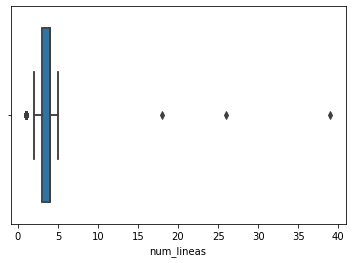

In [294]:
# Para la detección de outliers, primero comprobaré las medidas más importantes en cada
# variable mediante un .describe(). Posteriormente, las variables sospechosas se graficarán
# mediante un boxplot y se decidirá cómo imputar los outliers.
tabla_resumen_dic = union_diciembre.describe()
tabla_resumen_en = union_enero.describe()

# Visualizando las tablas y fijándome los respectivos máximos y cuartiles de las variables, 
# he decidido que se representará en un boxplot la variable num_lineas por las diferencias
# que hay entre su 3er cuartil y su máximo

import seaborn as sns

sns.boxplot(x=union_diciembre['num_lineas'])
sns.boxplot(x=union_enero['num_lineas'])

# Cuento valores diferentes en numero de líneas
union_diciembre['num_lineas'].value_counts() # Valores extraños: 18, 26, 39
union_enero['num_lineas'].value_counts()

# En num_lineas, en union_diciembre, hay tres valores atípicos muy por encima del valor 5, 
# el cual es el máximo en union_enero. Por ello, voy a cambiar los valores 18, 26, 39 por el máximo sin
# outliers, que sería 5 líneas. Esto lo haré porque 18 líneas de teléfono a nombre de una misma persona
# son muchas líneas, a no ser que sea de una empresa.

# Los analizo en profundidad por si acaso antes de imputarlos:
union_diciembre[union_diciembre.num_lineas == 18]
union_diciembre[union_diciembre.num_lineas == 26]
union_diciembre[union_diciembre.num_lineas == 39]

# Según sus demás valores, no parece diferenciarse mucho, por lo tanto, como se ha comentado anteriormente,
# se van a sustituir sus valores por 5 líneas.
union_diciembre['num_lineas'] = union_diciembre['num_lineas'].replace(18,5).replace(26,5).replace(39,5)

In [295]:
# Comprobación valores sin nulos ni datos 'objeto'
union_diciembre.isnull().sum()
union_enero.isnull().sum()

union_diciembre.dtypes
union_enero.dtypes

id                      int64
edad                    int64
facturacion           float64
antiguedad_dias         int64
num_lineas              int64
num_dt                  int32
incidencia              int64
num_llamad_ent          int64
num_llamad_sal          int64
mb_datos                int64
seg_llamad_ent          int64
seg_llamad_sal          int64
financiacion            int64
imp_financ            float64
descuentos              int64
conexion                int32
vel_conexion_mb         int32
comunidad_autonoma      int32
tv_tv-familiar          uint8
tv_tv-futbol            uint8
tv_tv-total             uint8
dtype: object

##### Tanto la tabla union_diciembre como union_enero están libres de valores nulos y libres de datos 'object'. Hay algunas variables cuyos valores se podrían agrupar, pero esto se llevará a cabo, si se considera oportuno, en la mejora de modelos. Además de la agrupación de variables, en el apartado de mejora de modelos también se valorará otros aspectos, como la selección de las mejores variables que funcionen en el modelo, quedándome sólo con ellas.

#### 2.5 Revisión gráfica de distribución de variables

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'edad'}>,
        <AxesSubplot:title={'center':'facturacion'}>,
        <AxesSubplot:title={'center':'antiguedad_dias'}>,
        <AxesSubplot:title={'center':'num_lineas'}>],
       [<AxesSubplot:title={'center':'num_dt'}>,
        <AxesSubplot:title={'center':'incidencia'}>,
        <AxesSubplot:title={'center':'num_llamad_ent'}>,
        <AxesSubplot:title={'center':'num_llamad_sal'}>,
        <AxesSubplot:title={'center':'mb_datos'}>],
       [<AxesSubplot:title={'center':'seg_llamad_ent'}>,
        <AxesSubplot:title={'center':'seg_llamad_sal'}>,
        <AxesSubplot:title={'center':'financiacion'}>,
        <AxesSubplot:title={'center':'imp_financ'}>,
        <AxesSubplot:title={'center':'descuentos'}>],
       [<AxesSubplot:title={'center':'conexion'}>,
        <AxesSubplot:title={'center':'vel_conexion_mb'}>,
        <AxesSubplot:title={'center':'abandona'}>,
        <AxesSubplot:title={'center':'

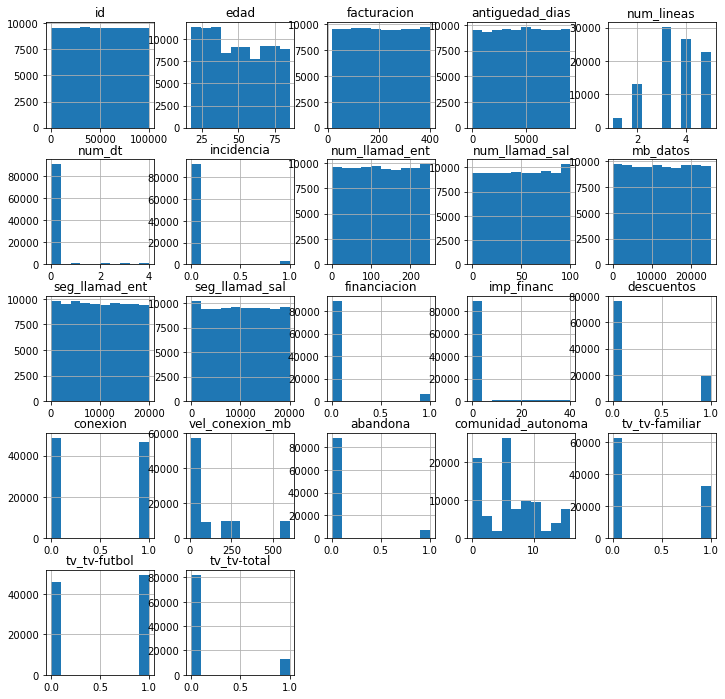

In [296]:
union_diciembre.hist(figsize=(12,12))
    
# Esta revisión servirá para la posterior mejora del modelo

### 3. Muestrear los datos, construyendo un dataset de train y test.
####  El muestreo será estratificado. El conjunto de entrenamiento y de test saldrá de union_diciembre. Las predicciones, las cuales se realizarán en un apartado posterior, serán en el conjunto union_enero.

In [297]:
# Antes de muestrear, selecciono la variable id como índice en ambas tablas (union_diciembre y union_enero)
# y en union_diciembre quito la variable objetivo (abandona). Esto se podría haber realizado previamente al 
# realizar la limpieza y el preprocesado del tablón union_diciembre

union_diciembre.set_index(['id'], inplace = True)
union_enero.set_index(['id'], inplace = True)

variable_abandona = union_diciembre['abandona']

# Quito la variable target en union_diciembre
union_diciembre.drop(columns = ['abandona'], inplace = True)

# Muestreo los datos
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(union_diciembre,
                                         variable_abandona,
                                         test_size = 0.2,
                                         random_state = 123,
                                         stratify = variable_abandona)

# Compruebo dimensiones
x_train.shape # (76373, 20)
y_train.shape # (76373, 1)

x_test.shape # (19094, 20)
y_test.shape # (19094, 1)

# Uno datos de train en conjunto_train. Defino conjunto_train, aunque al realizar la regresión los utilizaré
# separados (x_train, y_train), ya que queda más claro así
conjunto_train = pd.concat([x_train, y_train], axis = 1)

# Defino conjunto_test
conjunto_test = x_test



### 4. Construir un modelo analítico de clasificación que sea capaz de predecir cuando un cliente se fuga de la empresa, argumentando el tipo de algoritmo utilizado, las variables seleccionadas, obteniendo las métricas oportunas… Explicar lo “bueno” o “malo” que es el modelo a través de las métricas obtenidas

##### Para este caso, en el que la variable target es si el cliente abandona o no la compañía, se realizará un modelo de clasificación. En este caso se van a utilizar varios tipos (regresión logística, random forest, etc) con el objetivo de quedarme con el óptimo de cara a las métricas. Para las métricas de evaluación se utilizará la matriz de confusión, donde se sacará el accuracy, precision y recall. Además, también se evaluará por la curva ROC (área bajo la curva)

matriz de confusión
[[17585    92]
 [ 1114   303]]
accuracy
0.9368387975280192
precision
0.7670886075949367
recall
0.21383203952011293
f1
0.3344370860927153
AUC
0.6043137682467907


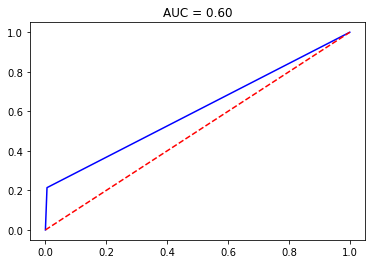

In [298]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
import matplotlib.pyplot  as plt

# Regresión logística
lr_classifier = LogisticRegression(solver = 'liblinear', random_state = 123).fit(x_train, y_train)
y_pred = lr_classifier.predict(x_test)

# Función para sacar las métricas
def saca_metricas(y1, y2):
    print('matriz de confusión')
    print(confusion_matrix(y1, y2))
    print('accuracy')
    print(accuracy_score(y1, y2))
    print('precision')
    print(precision_score(y1, y2))
    print('recall')
    print(recall_score(y1, y2))
    print('f1')
    print(f1_score(y1, y2))
    false_positive_rate, recall, thresholds = roc_curve(y1, y2)
    roc_auc = auc(false_positive_rate, recall)
    print('AUC')
    print(roc_auc)
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc)
    
# Saco las métricas del modelo mediante la función anterior
saca_metricas(y_test, y_pred)

##### Las variables seleccionadas en este primer modelo han sido todas las que había inicialmente en el dataset, puesto que en el apartado de feature engineering se realizarán cambios (ya sea para quitar, transformar o añadir variables).
##### El modelo en general es bastante malo. El accuracy es bueno, con un 93%, pero los demás parámetros, exceptuando la precisión, son bastante malos. El recall, por ejemplo, es muy bajo (21%) porque hay bastantes falsos negativos (1.115). La precisión es algo mejor, con un 78%. La F1, que relaciona la precisión y el recall es mala (33%) y el área bajo la curva es bastante malo (60%).
##### Al interpretar la matriz de confusión se ve como el modelo capta 17.585 negativos reales, dejándose 92 como falsos positivos y 303 positivos reales, dejándose 1.114 como falsos negativos. Esta última línea de la matriz de confusión es la que más preocupa (lo poco capaz que es el modelo de reconocer a los positivos reales).
##### A continuación probaré con otros tipos de modelos:

matriz de confusión
[[17048   629]
 [  562   855]]
accuracy
0.9376243846234419
precision
0.5761455525606469
recall
0.6033874382498235
f1
0.5894519131334022
AUC
0.7839022386700835


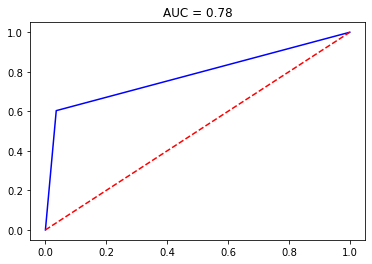

In [299]:
# Árbol de decisión
dt_classifier = DecisionTreeClassifier(random_state = 123).fit(x_train, y_train)
y_pred        = dt_classifier.predict(x_test)

# Saco las métricas del modelo mediante la función anterior
saca_metricas(y_test, y_pred)

##### Con el árbol de decisión se obtienen mejores resultados que con la regresión logística. El accuracy es de un 94% mientras que la precisión es de un 58% (baja con respecto al modelo de regresión logística). Sin embargo, el parámetro recall (58%) y la f1 (59%)  suben bastante con respecto al anterior modelo. El área bajo la curva ROC también sube considerablemente respecto al anterior modelo (78%). 
##### Este modelo identifica mejor los que sí que abandonan, mientras que identifica peor a los que no abandonan respecto al anterior modelo (tiene más falsos positivos y menos falsos negativos que el de regresión logística).
##### A continuación se probarán más modelos:

matriz de confusión
[[17605    72]
 [  588   829]]
accuracy
0.9654341678014036
precision
0.9200887902330743
recall
0.5850388143966125
f1
0.7152717860224331
AUC
0.7904828625357504


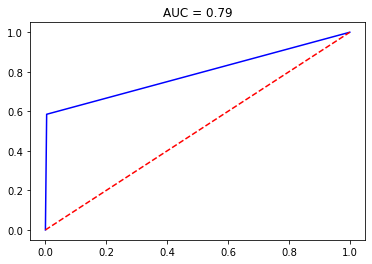

In [300]:
# Random forest
rf_classifier = RandomForestClassifier(random_state = 123).fit(x_train, y_train)
y_pred        = rf_classifier.predict(x_test)

# Saco las métricas del modelo mediante la función anterior
saca_metricas(y_test, y_pred)

##### El modelo de random forest mejora mucho más la precisión del modelo que tenía el modelo de árboles de decisión. El recall se queda prácticamente igual, por lo que la F1 aumenta considerablemente también (71%). Los demás parámetros quedan relativamente constantes (accuracy aumenta 3 pp, AUC aumenta 1 pp). 
##### De momento este es el mejor modelo, aunque se van a probar más:

matriz de confusión
[[17677     0]
 [ 1417     0]]
accuracy
0.925788205719074
precision
0.0
recall
0.0
f1
0.0
AUC
0.5


C:\Users\jaime\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


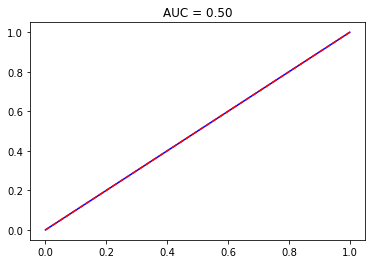

In [301]:
# SVM
svm_classifier = SVC(random_state = 123).fit(x_train, y_train)
y_pred         = svm_classifier.predict(x_test)

# Saco las métricas del modelo mediante la función anterior
saca_metricas(y_test, y_pred)

##### Como se puede observar, es el peor modelo hasta ahora. No reconoce ningún 1. 
##### Por último se probará el modelo de Naive Bayes

matriz de confusión
[[14773  2904]
 [   66  1351]]
accuracy
0.8444537551063162
precision
0.31750881316098706
recall
0.9534227240649259
f1
0.4763751763046544
AUC
0.8945707273093765


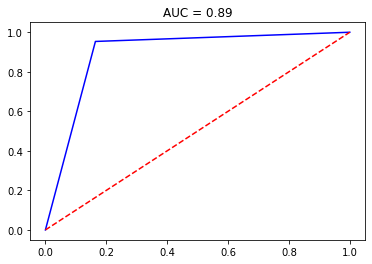

In [302]:
# Naive Bayes
nb_classifier1 = naive_bayes.GaussianNB().fit(x_train, y_train)
y_pred        = nb_classifier1.predict(x_test)

# Saco las métricas del modelo mediante la función anterior
saca_metricas(y_test, y_pred)

##### En cuanto al parámetro recall (distinguir a los verdaderos 1) es el mejor modelo con un 95%. Distingue 1.351 positivos reales, dejando sólo 66 como falsos negativos. El accuracy y precision bajan con respecto al modelo de random forest, así como la f1. Sin embargo, el área bajo la curva ROC aumenta considerablemente (89%) respecto al mejor modelo que se tenía hasta ahora, que era el Random Forest. 
##### El principal problema que tendría este modelo es en distinguir los 0 reales, es decir, los que no se van de la compañía. 
##### A continuación se redacta una conclusión para la elección de alguno de estos modelos

##### El objetivo principal de negocio sería saber con la mayor precisión posible los clientes que potencialmente se podrían perder. En este caso, debido a lo que se busca de cara al negocio, el modelo que elegiría sería el de Naive Bayes, puesto que es el que mejor distingue a los que realmente se van en el conjunto de entrenamiento con mucha diferencia respecto a los demás (se observa en el parámetro de recall). Escogiendo este modelo renuncio a parte de la precisión que otorgaba modelos como el Random Forest, que predecía mejor qué clientes se quedaban. Sin embargo, como ya he comentado, de cara a negocio me parece más valioso tener un modelo que tenga más precisión en cuanto a las personas que podrían abandonar la compañía, puesto que ese es el objetivo.
##### 
##### Estas conclusiones sirven de forma tentativa, pues después del apartado de feature engineering se volverán a tirar los mismos modelos para ver cuánto mejoran y cómo. Al final el modelo con mejor puntuaciones después de ese apartado será el escogido y con el que se harán las predicciones en el conjunto de enero.

### 5. Realizar una mejora del modelo utilizando técnicas vistas en clase (feature engineering, análisis de variables, comprobación de overfitting, validación cruzada, tuneado de hiper parámetros a través de la automatización…)

In [303]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression 
from sklearn.feature_selection import chi2 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

# Nombro union_diciembre (tabla principal de entrenamiento) como data_train,
# puesto que se va a realizar otro muestreo después de la transformación
# de las variables

union_diciembre = pd.concat([union_diciembre, variable_abandona], axis = 1)
data_train = union_diciembre

#### 5.1 Correlaciones respecto a la variable objetivo antes de realizar feature engineering

In [304]:
##### Correlaciones respecto a la variable objetivo
# De momento no haré selección de variables, pues quiero analizar cómo se correlaciona cada variable con la variable objetivo
# Saco correlaciones
corr = abs(data_train.corr())
corr[['abandona']].sort_values(by = 'abandona', ascending = False)

# Funcionan muy bien num_dt (nº líneas en impago), edad e incidencia sobre todo.

,abandona
abandona,1.000000
num_dt,0.312795
edad,0.296835
incidencia,0.277408
tv_tv-futbol,0.152493
descuentos,0.141447
tv_tv-total,0.111106
tv_tv-familiar,0.079990
financiacion,0.074597
imp_financ,0.067626


In [305]:
# Visualización de cómo se comportan las variables frente a la target
def proporciones_final (var,target,df):

    proporcion = pd.DataFrame()
    
    proporcion['%abandona'] = df[target].groupby(df[var]).mean()*100
    proporcion['Conteo'] = df[target].groupby(df[var]).count()
    proporcion= proporcion.round(3)   
    proporcion_filtered = proporcion[(proporcion['%abandona']>0) & (proporcion['Conteo']>10)]
        
    if len(proporcion_filtered)<100 and len(proporcion_filtered)>1:
        fig = plt.figure()
        ax = proporcion_filtered['Conteo'].plot(kind='bar',grid=True)
                
        ax2 = ax.twinx()
        ax2.plot(proporcion_filtered['%abandona'].values, linestyle='-', linewidth=2.0,color='g')
        plt.tight_layout()        
    else:        
        proporcion_filtered.reset_index(inplace=True)
        sns.lmplot(x = var,y ='%abandona',data=proporcion_filtered, fit_reg=True,ci=None)  

C:\Users\jaime\anaconda3\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


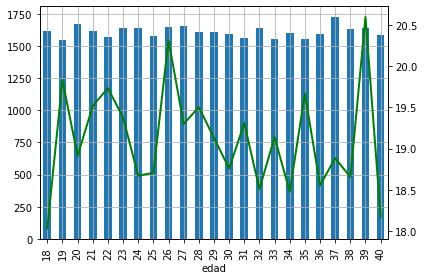

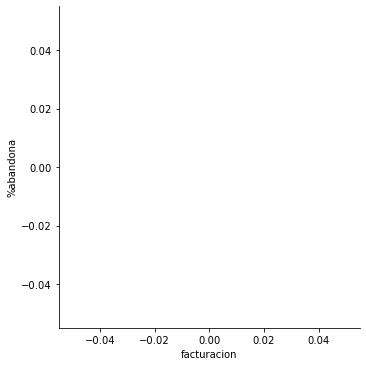

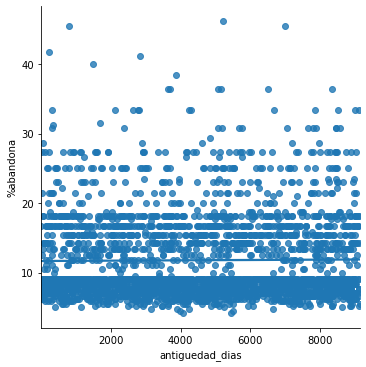

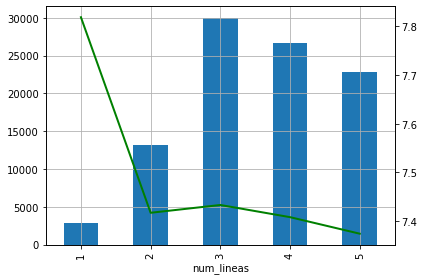

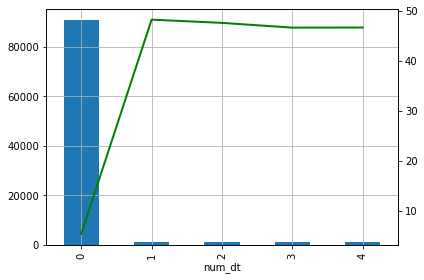

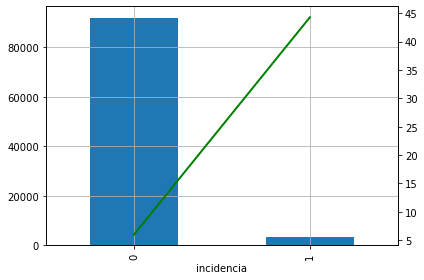

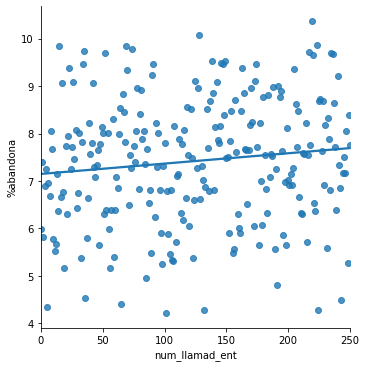

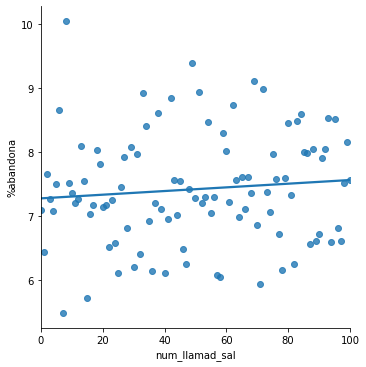

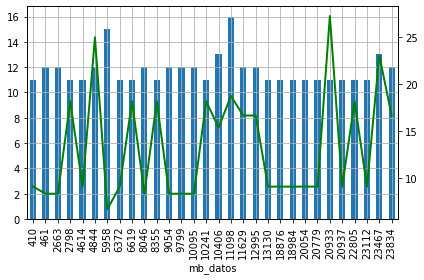

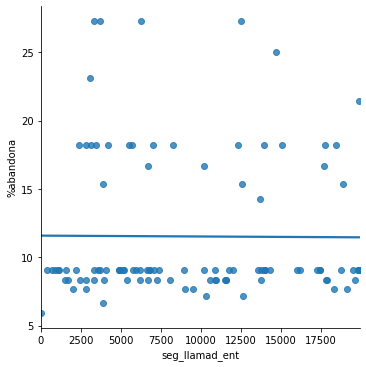

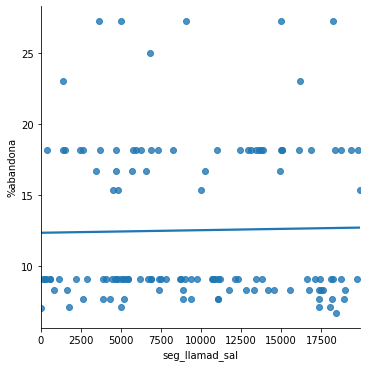

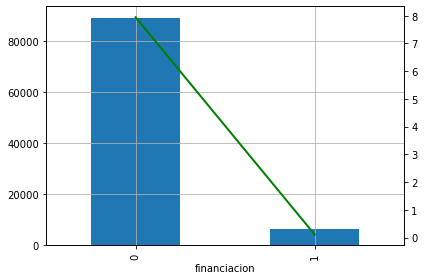

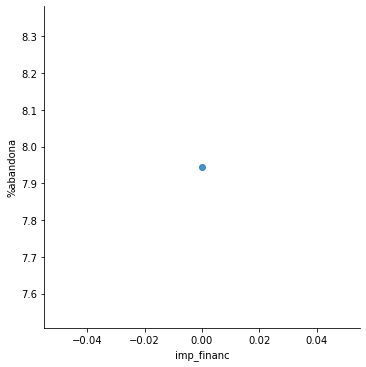

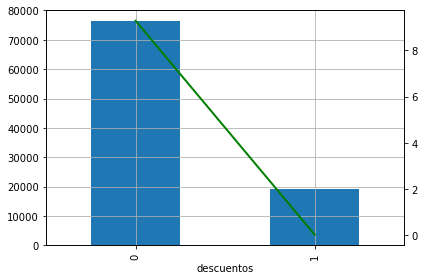

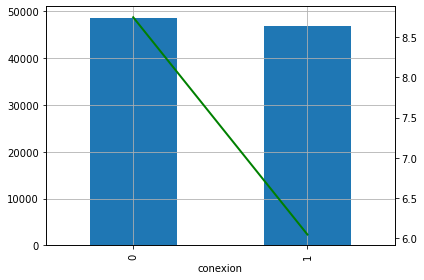

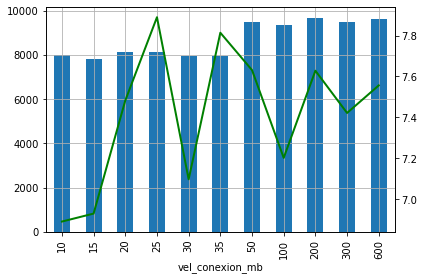

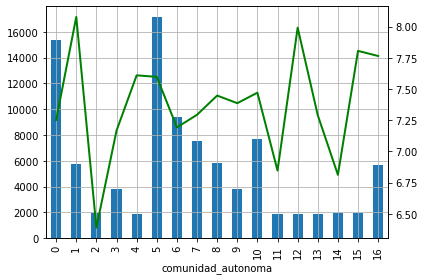

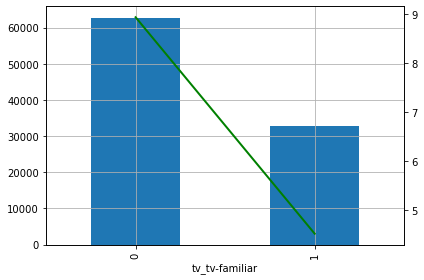

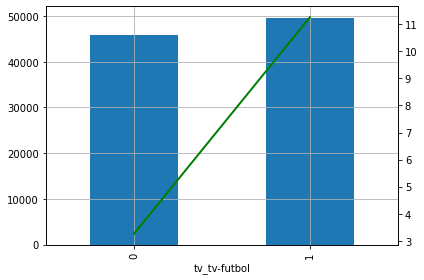

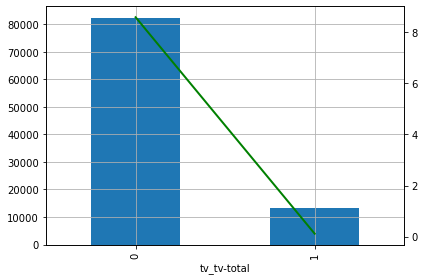

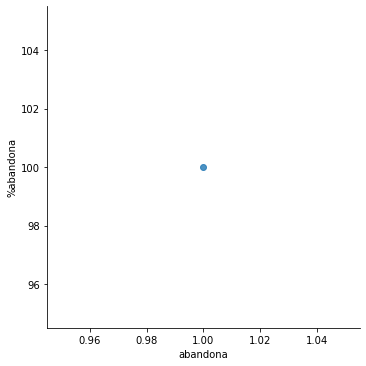

In [306]:
for i in data_train.columns:
    proporciones_final (i, 'abandona', data_train)

#### 5.2 Feature Engineering

In [307]:
data_train.describe()

,edad,facturacion,antiguedad_dias,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,...,financiacion,imp_financ,descuentos,conexion,vel_conexion_mb,comunidad_autonoma,tv_tv-familiar,tv_tv-futbol,tv_tv-total,abandona
count,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,...,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000
mean,49.779379,207.392912,4573.466308,3.558549,0.124242,0.037437,124.815633,50.022762,12489.795898,9945.152849,...,0.066746,1.486331,0.200635,0.490609,136.514502,6.263808,0.343009,0.519907,0.137084,0.074214
std,19.832963,111.343491,2630.421952,1.086122,0.598773,0.189831,72.492338,29.119904,7239.421267,5784.158514,...,0.249582,6.148373,0.400477,0.499914,179.273914,4.616285,0.474717,0.499606,0.343938,0.262120
min,18.000000,15.000439,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,111.383822,2309.000000,3.000000,0.000000,0.000000,62.000000,25.000000,6177.500000,4951.000000,...,0.000000,0.000000,0.000000,0.000000,20.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,49.000000,206.808431,4587.000000,4.000000,0.000000,0.000000,124.000000,50.000000,12466.000000,9923.000000,...,0.000000,0.000000,0.000000,0.000000,35.000000,6.000000,0.000000,1.000000,0.000000,0.000000
75%,67.000000,304.436599,6851.000000,4.000000,0.000000,0.000000,188.000000,75.000000,18785.500000,14948.500000,...,0.000000,0.000000,0.000000,1.000000,200.000000,9.000000,1.000000,1.000000,0.000000,0.000000
max,85.000000,399.998433,9130.000000,5.000000,4.000000,1.000000,250.000000,100.000000,25000.000000,20000.000000,...,1.000000,39.990128,1.000000,1.000000,600.000000,16.000000,1.000000,1.000000,1.000000,1.000000


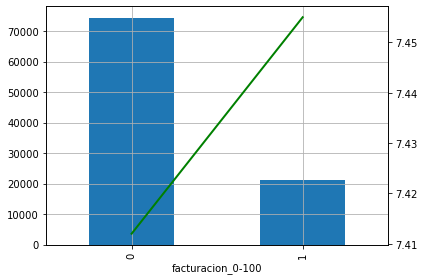

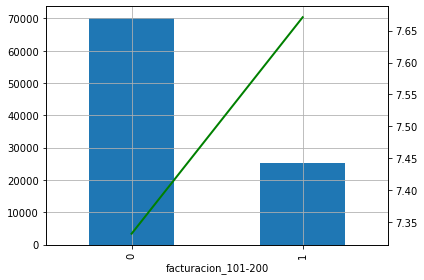

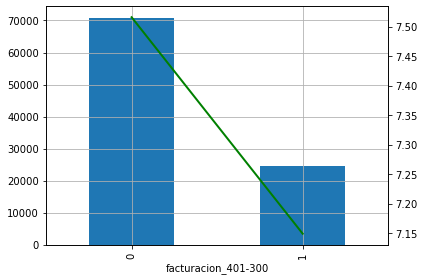

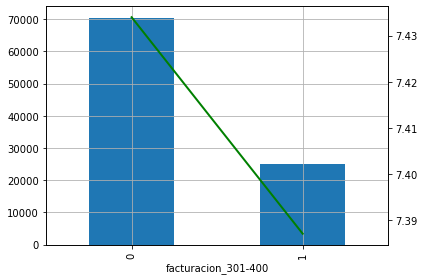

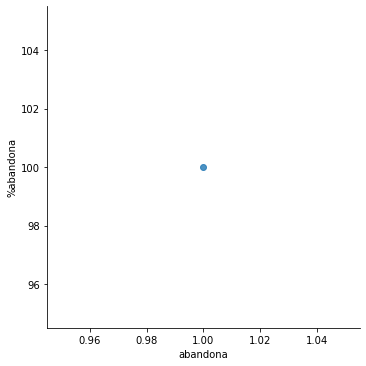

In [308]:
# Tramearé la variable edad para ver si mejora su correlación
# Función para tramear

def tramos(varib,varib_destino,tamanio,maximo,df):
    df[varib_destino]=np.where(df[varib]==0,-1,(df[varib]//tamanio)*tamanio)
    df[varib_destino]=np.where(df[varib_destino]>=maximo,maximo,df[varib_destino])

data_train_ori = data_train
data_train = data_train_ori

##### Edad
# Trameo por las variaciones de correlación con la var. objetivo en el gráfico aproximadamente

data_train['edad_18-23'] = data_train['edad'].apply(lambda x: 1 if x<=23 else 0)
data_train['edad_24-29'] = data_train['edad'].apply(lambda x: 1 if x>23 & x<30 else 0)
data_train['edad_30-38'] = data_train['edad'].apply(lambda x: 1 if x>29 & x<39 else 0)
data_train['edad_39-50'] = data_train['edad'].apply(lambda x: 1 if x>38 & x<51 else 0)
data_train['edad_51-65'] = data_train['edad'].apply(lambda x: 1 if x>50 & x<66 else 0)
data_train['edad_66-85'] = data_train['edad'].apply(lambda x: 1 if x>65 else 0)
data_train['edad_nueva'] = data_train['edad'].apply(lambda x: 0 if x<=23 else (1 if x>23 and x<30 
                                                                              else(2 if x>29 and x<39 
                                                                                   else(3 if x>38 and x<51 
                                                                                        else(4 if x>50 and x<66 
                                                                                             else(5))))))  
# La variable 'edad_nueva' tiene una correlación de 0.306 con la variable objetivo
# mientras que la variable 'edad' original tenía una correlación de 0.297. Por lo tanto
# algo se ha ganado con el trameo de la variable.


##### Facturación
# Previamente a ver el gráfico de la correlación de esta variable con la objetivo, se va
# a agrupar para poder hacer un diagrama de barras en función de su distribución
data_train.facturacion.describe()

data_train['facturacion_0-100'] = data_train['facturacion'].apply(lambda x: 1 if x<=100 else 0)
data_train['facturacion_101-200'] = data_train['facturacion'].apply(lambda x: 1 if x>100 and x<201 else 0)
data_train['facturacion_401-300'] = data_train['facturacion'].apply(lambda x: 1 if x>200 and x<301 else 0)
data_train['facturacion_301-400'] = data_train['facturacion'].apply(lambda x: 1 if x>300 and x<401 else 0)
data_train['facturacion_nueva'] = data_train['facturacion'].apply(lambda x: 0 if x<=100 else (1 if x>100 and x<201 
                                                                              else(2 if x>200 and x<301 
                                                                                   else(3 if x>300 and x<401 
                                                                                            else(4)))))

# Represento la facturación trameada anteriormente frente a la variable objetivo
df_facturacion = pd.DataFrame(data_train.loc[:,['facturacion_0-100','facturacion_101-200', 'facturacion_401-300',
                                                'facturacion_301-400', 'abandona']])

for i in df_facturacion.columns:
    proporciones_final (i, 'abandona', df_facturacion)
    
# En los gráficos se puede observar como dependiendo de la facturación, hay más probabilidad de abandono o no.

##### Antigüedad_días
# Lo agruparé por años hasta el quinto, que a partir de ese será todos los demás también

data_train['antiguedad_0-365'] = data_train['antiguedad_dias'].apply(lambda x: 1 if x<=365 else 0)
data_train['antiguedad_366-730'] = data_train['antiguedad_dias'].apply(lambda x: 1 if x>365 and x<731 else 0)
data_train['antiguedad_731-1095'] = data_train['antiguedad_dias'].apply(lambda x: 1 if x>730 and x<1096 else 0)
data_train['antiguedad_1096-1460'] = data_train['antiguedad_dias'].apply(lambda x: 1 if x>1095 and x<1461 else 0)
data_train['antiguedad_1461-1825'] = data_train['antiguedad_dias'].apply(lambda x: 1 if x>1460 and x<1826 else 0)
data_train['antiguedad_1826-omas'] = data_train['antiguedad_dias'].apply(lambda x: 1 if x>1825 else 0)
data_train['antiguedad_nueva'] = data_train['antiguedad_dias'].apply(lambda x: 0 if x<=365 else (1 if x>365 and x<731 
                                                                              else(2 if x>730 and x<1096 
                                                                                   else(3 if x>1095 and x<1461 
                                                                                        else(4 if x>1460 and x<1826 
                                                                                            else(5)))))) 
# Algo mejora en cuanto a correlación con la variable objetivo (pasa de 0.002 a 0.007)

##### num_dt
# Voy a agruparlo en 0 y 1 o más
data_train['num_dt_0'] = data_train['num_dt'].apply(lambda x: 1 if x<=0 else 0)
data_train['num_dt_1-omas'] = data_train['num_dt'].apply(lambda x: 1 if x>0 and x<6 else 0)
data_train['num_dt_nueva'] = data_train['num_dt'].apply(lambda x: 0 if x<=0 else(5))

# Mejora los resultados de correlación con la variable objetivo de num_dt bastante, que, además,
# era la que más estaba correlacionada con la variable objetivo (0.347 vs 0.313)

##### mb_datos
# Agrupo según gráfico aprox.
data_train.mb_datos.describe()

data_train['mb_datos_0-6500'] = data_train['mb_datos'].apply(lambda x: 1 if x<=6500 else 0)
data_train['mb_datos_6501-9000'] = data_train['mb_datos'].apply(lambda x: 1 if x>6500 and x<9001 else 0)
data_train['mb_datos_9001-10500'] = data_train['mb_datos'].apply(lambda x: 1 if x>9000 and x<10501 else 0)
data_train['mb_datos_10501-17000'] = data_train['mb_datos'].apply(lambda x: 1 if x>10500 and x<17001 else 0)
data_train['mb_datos_17001-19500'] = data_train['mb_datos'].apply(lambda x: 1 if x>17000 and x<19501 else 0)
data_train['mb_datos_19501-omas'] = data_train['mb_datos'].apply(lambda x: 1 if x>19500 else 0)
data_train['mb_datos_nuevo'] = data_train['mb_datos'].apply(lambda x: 0 if x<=6500 else (1 if x>6500 and x<9001 
                                                                              else(2 if x>9000 and x<10501 
                                                                                   else(3 if x>10500 and x<17001 
                                                                                        else(4 if x>17000 and x<19501 
                                                                                            else(5)))))) 

##### seg_llamad_ent
# Agrupo según gráfico aprox.
data_train.seg_llamad_ent.describe()

data_train['seg_ll_ent_0-3460'] = data_train['seg_llamad_ent'].apply(lambda x: 1 if x<=3460 else 0)
data_train['seg_ll_ent_3461-3940'] = data_train['seg_llamad_ent'].apply(lambda x: 1 if x>3460 and x<3941 else 0)
data_train['seg_ll_ent_3941-7100'] = data_train['seg_llamad_ent'].apply(lambda x: 1 if x>3940 and x<7101 else 0)
data_train['seg_ll_ent_7101-12040'] = data_train['seg_llamad_ent'].apply(lambda x: 1 if x>7100 and x<12041 else 0)
data_train['seg_ll_ent_12040-13500'] = data_train['seg_llamad_ent'].apply(lambda x: 1 if x>12040 and x<13501 else 0)
data_train['seg_ll_ent_13501-20000'] = data_train['seg_llamad_ent'].apply(lambda x: 1 if x>13500 else 0)
data_train['seg_ll_ent_nuevo'] = data_train['seg_llamad_ent'].apply(lambda x: 0 if x<=3460 else (1 if x>3460 and x<3941 
                                                                              else(2 if x>3940 and x<7101 
                                                                                   else(3 if x>7100 and x<12041 
                                                                                        else(4 if x>12040 and x<13501 
                                                                                            else(5)))))) 

##### Vel_conexion_mb
# Agrupo según gráfico aprox.
data_train['vel_conexion_mb'].describe()

data_train['vel_conexion_10-20'] = data_train['vel_conexion_mb'].apply(lambda x: 1 if x<=10 else 0)
data_train['vel_conexion_21-27'] = data_train['vel_conexion_mb'].apply(lambda x: 1 if x>10 and x<28 else 0)
data_train['vel_conexion_28-32'] = data_train['vel_conexion_mb'].apply(lambda x: 1 if x>27 and x<33 else 0)
data_train['vel_conexion_33-50'] = data_train['vel_conexion_mb'].apply(lambda x: 1 if x>32 and x<51 else 0)
data_train['vel_conexion_51-170'] = data_train['vel_conexion_mb'].apply(lambda x: 1 if x>50 and x<171 else 0)
data_train['vel_conexion_171-300'] = data_train['vel_conexion_mb'].apply(lambda x: 1 if x>172 and x<301 else 0)
data_train['vel_conexion_301-600'] = data_train['vel_conexion_mb'].apply(lambda x: 1 if x>300 else 0)
data_train['vel_conexion_nuevo'] = data_train['vel_conexion_mb'].apply(lambda x: 0 if x<=10 else (1 if x>10 and x<28 
                                                                              else(2 if x>27 and x<33 
                                                                                   else(3 if x>32 and x<51 
                                                                                        else(4 if x>50 and x<171 
                                                                                             else(5 if x>172 and x<301
                                                                                                  else(6))))))) 

# Mejora algo frente a la variable original

#### 5.3 Selección de variables 

In [309]:
from sklearn.feature_selection import chi2 

S_chi5 = SelectKBest(chi2, k = 15)
X_chi5 = S_chi5.fit_transform(data_train, data_train['abandona'])

variables = list(np.asarray(list(data_train))[S_chi5.get_support()])
variables.sort()
print(variables)

['abandona', 'antiguedad_dias', 'descuentos', 'edad', 'edad_18-23', 'edad_66-85', 'edad_nueva', 'imp_financ', 'incidencia', 'mb_datos', 'num_dt', 'num_dt_1-omas', 'num_dt_nueva', 'tv_tv-futbol', 'tv_tv-total']


In [310]:
# Selecciono las variables con las que me quedaría
columnas_fe = ['abandona', 'edad_nueva', 'imp_financ', 'incidencia', 'num_dt_nueva', 'tv_tv-futbol', 
               'descuentos', 'tv_tv-total']

# Probando modelos, veo que mb_datos y antiguedad_dias no aportan, por lo tanto no las meto.
data_train_fe = data_train[columnas_fe]

#### 5.4 Modelos con variables seleccionadas

In [311]:
# Vuelvo a tirar el modelo con las variables seleccionadas
# Separo la variable objetivo y la borro del dataset
var_obj = pd.DataFrame(data_train_fe['abandona'])
data_train_fe = data_train_fe.drop('abandona', axis = 1)

# Train y test
x_train, x_test, y_train, y_test = train_test_split(data_train_fe,
                                                    var_obj,
                                                    test_size=0.2,
                                                    random_state=123,
                                                    stratify = var_obj)

C:\Users\jaime\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


matriz de confusión
[[17578    99]
 [  674   743]]
accuracy
0.9595160783492197
precision
0.8824228028503563
recall
0.5243472124206069
f1
0.6578131916777334
AUC
0.7593733572992891


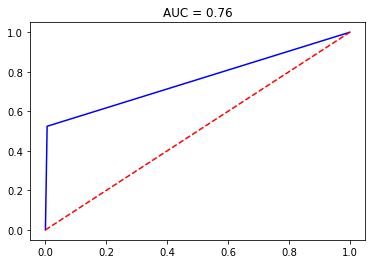

In [312]:
# Regresión logística
lr_classifier = LogisticRegression(solver = 'liblinear', random_state = 123).fit(x_train, y_train)
y_pred = lr_classifier.predict(x_test)

# Métricas
saca_metricas(y_test, y_pred)

##### La regresión logística anterior, con variables seleccionadas, da mejor resultado que sin variables seleccionadas.

matriz de confusión
[[17582    95]
 [  671   746]]
accuracy
0.9598826856604169
precision
0.8870392390011891
recall
0.5264643613267467
f1
0.6607617360496014
AUC
0.760545073122501


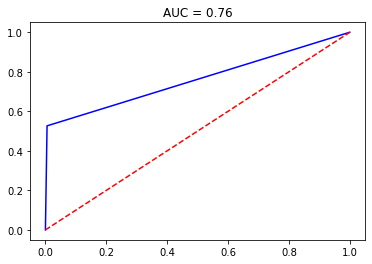

In [313]:
# Árbol de decisión
dt_classifier = DecisionTreeClassifier(random_state = 123).fit(x_train, y_train)
y_pred        = dt_classifier.predict(x_test)

# Métricas
saca_metricas(y_test, y_pred)

# Peor resultado en el árbol de decisión que el anterior árbol de decisión.

<ipython-input-314-cf46d3157f60>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier = RandomForestClassifier(random_state = 123).fit(x_train, y_train)


matriz de confusión
[[17570   107]
 [  656   761]]
accuracy
0.9600398030795014
precision
0.8767281105990783
recall
0.5370501058574453
f1
0.6660831509846826
AUC
0.7654985212774243


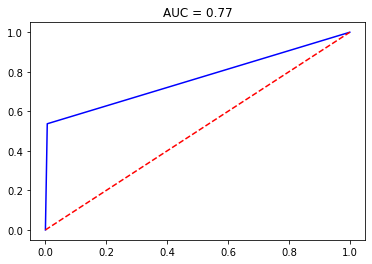

In [314]:
# Random forest
rf_classifier = RandomForestClassifier(random_state = 123).fit(x_train, y_train)
y_pred        = rf_classifier.predict(x_test)

# Métricas
saca_metricas(y_test, y_pred)

# Peor resultado en el random forest que el anterior random forest.

C:\Users\jaime\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


matriz de confusión
[[17545   132]
 [  655   762]]
accuracy
0.9587828637268252
precision
0.8523489932885906
recall
0.5377558221594919
f1
0.6594547814798789
AUC
0.7651442458650601


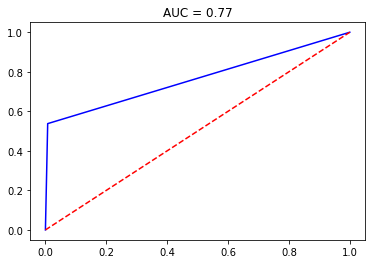

In [315]:
# SVM
svm_classifier = SVC(random_state = 123).fit(x_train, y_train)
y_pred         = svm_classifier.predict(x_test)

# Métricas
saca_metricas(y_test, y_pred)

# Mejor resultado que el anterior SVM.

matriz de confusión
[[12220  5457]
 [    5  1412]]
accuracy
0.7139415523201006
precision
0.20556121706216335
recall
0.9964714184897672
f1
0.3408158339367608
AUC
0.8438825950286704


C:\Users\jaime\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


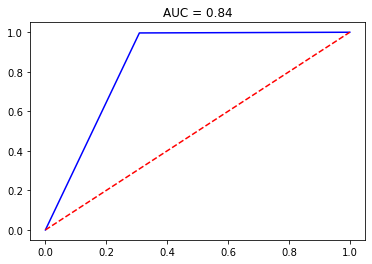

In [316]:
# Naive Bayes
nb_classifier = naive_bayes.GaussianNB().fit(x_train, y_train)
y_pred        = nb_classifier.predict(x_test)

# Métricas
saca_metricas(y_test, y_pred)

# Un poco peor que el anterior modelo de Bayes. 

##### El único modelo que mejora significativamente después de la selección de variables y la tramificación de las mismas es el modelo de regresión logística.

C:\Users\jaime\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jaime\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[19:05:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
matriz de confusión
[[12220  5457]
 [    5  1412]]
accuracy
0.7139415523201006
precision
0.20556121706216335
recall
0.9964714184897672
f1
0.3408158339367608
AUC
0.8438825950286704


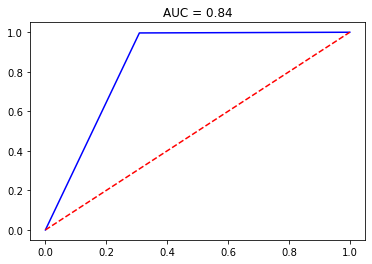

In [317]:
# Saco un nuevo modelo para probar: XGBOOST
from xgboost import XGBClassifier

# XGB
classifier3 = XGBClassifier(n_estimators = 1000).fit(x_train, y_train)
y_pred3    = classifier3.predict(x_test)

# Métricas
saca_metricas(y_test, y_pred)

# Resultado equivalente al de Bayes.

#### 5.5 Tuneado de hiper parámetros

In [1]:
# Se probará tunear varios modelos
# Regresión logística
grid_param = {
    'max_iter': [100, 500, 1000, 2000],
    'penalty': ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
}

# Sobre recall para intentar mejorar esa métrica
model_grid = GridSearchCV(estimator=lr_classifier,
                     param_grid=grid_param,
                     scoring='recall',
                     cv=5,
                     n_jobs=-1)

model_grid.fit(x_train, y_train)

NameError: name 'np' is not defined

In [319]:
print(model_grid.best_params_)

{'C': 0.08858667904100823, 'max_iter': 100, 'penalty': 'l1'}


In [320]:
print(model_grid.best_score_)

0.5160549866051485


matriz de confusión
[[15143  2534]
 [  117  1300]]
accuracy
0.8611605740023044
precision
0.33907146583202924
recall
0.9174311926605505
f1
0.4951437821367358
AUC
0.887040538345323


C:\Users\jaime\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


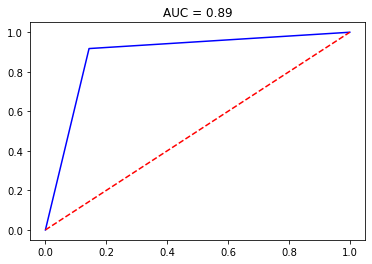

In [321]:
# Modelo regresión logística con mejores parámetros
classifier_bp = LogisticRegression(solver ="liblinear", C= 0.08858667904100823, max_iter= 100, 
                                   penalty= 'l1', class_weight = 'balanced').fit(x_train, y_train)

# Con los datos balanceados se consigue un score bastante bueno. Se puede pensar que los datos
# están poco balanceados.
y_pred = classifier_bp.predict(x_test) 

saca_metricas(y_test, y_pred)

In [322]:
print(classification_report(y_test, y_pred)) 
# En lo que fallaría sería en la precisión de los 1.

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     17677
           1       0.34      0.92      0.50      1417

    accuracy                           0.86     19094
   macro avg       0.67      0.89      0.71     19094
weighted avg       0.94      0.86      0.89     19094



In [323]:
# Para Random Forest
grid_param = {
    'n_estimators': [10, 20, 30, 80, 90],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'max_depth': [4,5,6,7,8,9,10,12,14,16]
}

# Intento optimizar el recall también
model_grid = GridSearchCV(estimator=rf_classifier,
                     param_grid=grid_param,
                     scoring='recall',
                     cv=5,
                     n_jobs=-1)

model_grid.fit(x_train, y_train)


C:\Users\jaime\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 12, 14, 16],
                         'n_estimators': [10, 20, 30, 80, 90]},
             scoring='recall')

In [324]:
print(model_grid.best_params_)

{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 20}


In [325]:
print(model_grid.best_score_)

0.5234659742750358


<ipython-input-326-045ed106fe51>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier_bp = RandomForestClassifier(bootstrap= False, criterion= 'gini',


matriz de confusión
[[17575   102]
 [  660   757]]
accuracy
0.9600921755525296
precision
0.8812572759022119
recall
0.534227240649259
f1
0.6652021089630932
AUC
0.7642285153860087


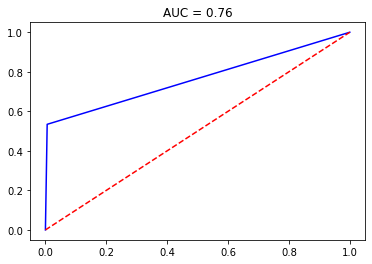

In [326]:
# Modelo random forest con mejores hiper parámetros
rf_classifier_bp = RandomForestClassifier(bootstrap= False, criterion= 'gini', 
                                          max_depth= 7, n_estimators= 10, 
                                          random_state = 123).fit(x_train, y_train)

y_pred = rf_classifier_bp.predict(x_test)

saca_metricas(y_test, y_pred)

In [327]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17677
           1       0.88      0.53      0.67      1417

    accuracy                           0.96     19094
   macro avg       0.92      0.76      0.82     19094
weighted avg       0.96      0.96      0.96     19094



#### 5.6 Comprobación de que no hay overfitting mediante validación cruzada

In [328]:
# Lo compruebo en los modelos con mejores resultados obtenidos:
    # Modelo regresión logística con hiper parámetros tuneados 
    # Modelo de Naive Bayes

# Para la regresión logística
results_LR = cross_val_score(estimator=classifier_bp, X=x_train, y=y_train, cv=5)

print(results_LR.mean()) 

C:\Users\jaime\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaime\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaime\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaime\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

0.8566639551138644


C:\Users\jaime\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [329]:
print(results_LR.std())

# Valores parecidos y varianza muy baja, no hay overfitting en el modelo de regresión
# logística

0.0028321844993386535


In [332]:
# Para Naive Bayes
results_NB = cross_val_score(estimator=nb_classifier1, X=x_train, y=y_train, cv=5)

print(results_NB.mean()) 

0.708719227415329


C:\Users\jaime\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaime\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaime\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jaime\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

In [333]:
print(results_NB.std())
# Valores parecidos y varianza muy baja, no hay overfitting en el modelo de Naive Bayes

0.03775545939725624


##### El modelo con el que me quedaría sería el de regresión logística después del tuneado de los hiper parámetros. Este modelo tiene las siguientes características:
##### 
##### Accuracy: 0.8611
##### Precision: 0.339
##### Recall: 0.917
##### F1: 0.495
##### AUC: 0.887
##### 
##### El modelo es capaz de reconocer a 15.143 'NO' reales y a 1.300 'SÍ' reales. No reconoce a 2.534 que se quedarían en la compañía, prediciendo el modelo que se irían y no reconoce a 117 que se irían de la compañía, predicciendo el modelo que se quedarían.
##### 
##### El motivo para escoger este modelo de regresión logística es, quitando que de forma general consigue la mejor puntuación en sus parámetros, su Recall, que, como se ha mencionado antes, creo que para el negocio sería importante reconocer mejor a los que se van para poder realizar alguna acción sobre ellos. Aunque el modelo de Naives Bayes tiene mejor Recall (sólo fallaría en 5 personas que clasificaría como que no se irían aunque sí se irían) este modelo predice demasiados falsos positivos, y, por  ello, se podría perder bastante dinero en dirigir acciones para esos falsos positivos aunque no se fueran a ir. Por eso he escogido el de regresión logística, porque en ese aspecto está más equilibrado. Sin embargo, podría haber escogido el de Naives Bayes perfectamente, puesto que son similares.
##### 
##### Lo que ha terminado de balancear el hecho de que escoja el de regresión logística es que el modelo es más sencillo. Este tiene selección de variables, mientras que el de Bayes no tiene, aunque si bien es cierto, el modelo de Bayes tampoco tiene variables transformadas, mientras que el de regresión logística sí.

### 6. Predecir los clientes de la cosecha de enero que más probabilidad tienen de cambiarse de operadora.

In [334]:
# El modelo ganador es la regresión logística después del tuneado de variables
modelo_ganador = classifier_bp

In [335]:
# Añado en union_enero las variables del modelo. Eran las siguientes:
# columnas_fe = ['edad_nueva', 'imp_financ', 'incidencia', 'num_dt_nueva', 'tv_tv-futbol', 
#               'descuentos', 'tv_tv-total']

# Añado variables
# Edad_nueva
union_enero['edad_18-23'] = union_enero['edad'].apply(lambda x: 1 if x<=23 else 0)
union_enero['edad_24-29'] = union_enero['edad'].apply(lambda x: 1 if x>23 & x<30 else 0)
union_enero['edad_30-38'] = union_enero['edad'].apply(lambda x: 1 if x>29 & x<39 else 0)
union_enero['edad_39-50'] = union_enero['edad'].apply(lambda x: 1 if x>38 & x<51 else 0)
union_enero['edad_51-65'] = union_enero['edad'].apply(lambda x: 1 if x>50 & x<66 else 0)
union_enero['edad_66-85'] = union_enero['edad'].apply(lambda x: 1 if x>65 else 0)
union_enero['edad_nueva'] = union_enero['edad'].apply(lambda x: 0 if x<=23 else (1 if x>23 and x<30 
                                                                              else(2 if x>29 and x<39 
                                                                                   else(3 if x>38 and x<51 
                                                                                        else(4 if x>50 and x<66 
                                                                                             else(5)))))) 

# num_dt_nueva
union_enero['num_dt_0'] = union_enero['num_dt'].apply(lambda x: 1 if x<=0 else 0)
union_enero['num_dt_1-omas'] = union_enero['num_dt'].apply(lambda x: 1 if x>0 and x<6 else 0)
union_enero['num_dt_nueva'] = union_enero['num_dt'].apply(lambda x: 0 if x<=0 else(5))

# Me quedo en union enero con las columnas que seleccioné en el entrenamiento. Lo llamo test_enero
test_enero = pd.DataFrame(union_enero[['edad_nueva', 'imp_financ', 'incidencia', 'num_dt_nueva', 'tv_tv-futbol', 
                         'descuentos', 'tv_tv-total']], index = union_enero.index)


In [336]:
# PREDICCIONES (1 - se van de la compañía; 0 - No se van de la compañía)
prediccion_abandona = modelo_ganador.predict(test_enero)

# Pongo la predicción de si abandona junto al dataframe de test_enero
prediccion_abandona = pd.DataFrame(prediccion_abandona, index = test_enero.index)

enero_con_predicciones = pd.merge(test_enero, prediccion_abandona, left_index = True, right_index = True)

# índice (que era el ID) lo vuelvo a poner como columna
enero_con_predicciones.reset_index(inplace=True)

enero_con_predicciones = enero_con_predicciones.rename(columns = {0:'abandona'})

enero_con_predicciones.head(10)

,id,edad_nueva,imp_financ,incidencia,num_dt_nueva,tv_tv-futbol,descuentos,tv_tv-total,abandona
0,1,4,0.000000,0,0,1,0,0,0
1,2,5,0.000000,0,0,1,1,0,0
2,3,5,0.000000,0,0,1,1,0,0
3,4,5,0.000000,0,0,0,0,0,0
4,6,4,0.000000,0,0,1,0,0,0
5,7,4,31.553269,0,0,1,0,0,0
6,8,0,0.000000,0,0,1,0,0,1
7,9,2,0.000000,0,0,0,0,1,0
8,11,4,0.000000,0,0,1,1,0,0
9,12,5,0.000000,0,0,0,1,1,0


In [337]:
# PROBABILIDADES (probabilidad de que se vayan de la compañía)
modelo_proba = modelo_ganador.predict_proba(test_enero)[:,1]

modelo_proba = (pd.DataFrame(modelo_proba,columns=['probabilidad'],index=test_enero.index))
modelo_proba.sort_values(by=['probabilidad'],ascending=False,axis=0,inplace=True)

enero_con_probabilidades = pd.merge(test_enero, modelo_proba, left_index = True, right_index = True)

# Pongo el id como variable y no como índice.
enero_con_probabilidades.reset_index(inplace=True)

# Ordeno de mayor a menor probabilidad
enero_con_probabilidades = enero_con_probabilidades.sort_values(by='probabilidad', ascending= False)

enero_con_probabilidades.head(10) # ordenado de mayor a menor probabilidad de que abandonen la compañía

,id,edad_nueva,imp_financ,incidencia,num_dt_nueva,tv_tv-futbol,descuentos,tv_tv-total,probabilidad
33406,36006,0,0.0,1,5,1,0,0,0.999898
22547,24282,0,0.0,1,5,1,0,0,0.999898
43372,46790,1,0.0,1,5,1,0,0,0.999729
62101,67018,1,0.0,1,5,1,0,0,0.999729
7040,7627,1,0.0,1,5,1,0,0,0.999729
39995,43153,0,0.0,1,5,0,0,0,0.999584
78346,84471,0,0.0,1,5,0,0,0,0.999584
6468,7016,2,0.0,1,5,1,0,0,0.999282
6405,6952,2,0.0,1,5,1,0,0,0.999282
53493,57715,2,0.0,1,5,1,0,0,0.999282


In [346]:
# Compruebo con ejemplos de id que cuadran los datos en probabilidad y en predicción
# Ejemplo: id 36006 -> probabilidad de que abandone: 0.999 (debería ser un 1 en predicción). Lo haré con
# todos los id que aparecen en la tabla anterior enero_con_probabilidades.head(10). Deberían ser todos
# 1 en abandona.

id_ejemplo = [36006, 24282, 46790, 67018, 7627, 43153, 84471, 7016, 6952, 57715]

enero_con_p_ejemplo = enero_con_predicciones[enero_con_predicciones['id'].isin(id_ejemplo)]

enero_con_p_ejemplo # Sí abandonan. Por lo tanto, funciona. Los que más probabilidades tienen, abandonan.

,id,edad_nueva,imp_financ,incidencia,num_dt_nueva,tv_tv-futbol,descuentos,tv_tv-total,abandona
6405,6952,2,0.0,1,5,1,0,0,1
6468,7016,2,0.0,1,5,1,0,0,1
7040,7627,1,0.0,1,5,1,0,0,1
22547,24282,0,0.0,1,5,1,0,0,1
33406,36006,0,0.0,1,5,1,0,0,1
39995,43153,0,0.0,1,5,0,0,0,1
43372,46790,1,0.0,1,5,1,0,0,1
53493,57715,2,0.0,1,5,1,0,0,1
62101,67018,1,0.0,1,5,1,0,0,1
78346,84471,0,0.0,1,5,0,0,0,1


In [347]:
# Coeficientes del modelo.
# Intercepto
intercepto_modelo_ganador = modelo_ganador.intercept_
print(intercepto_modelo_ganador)

[0.84694428]


In [348]:
# Coeficientes de parámetros
coeficientes_modelo_ganador = modelo_ganador.coef_
print(coeficientes_modelo_ganador)

[[-0.97379475 -0.24426169  3.43313224  0.70063971  1.40328797 -6.69247483
  -3.33160163]]


In [349]:
test_enero.columns

Index(['edad_nueva', 'imp_financ', 'incidencia', 'num_dt_nueva',
       'tv_tv-futbol', 'descuentos', 'tv_tv-total'],
      dtype='object')

In [350]:
# Fórmula modelo
print('logit(abandona) =',intercepto_modelo_ganador[0], ' + ',  coeficientes_modelo_ganador[0][0], '* edad_nueva + ',
      coeficientes_modelo_ganador[0][1], '* imp_financ + ', coeficientes_modelo_ganador[0][2], '* incidencia + ',
      coeficientes_modelo_ganador[0][3], '* num_dt_nueva +', coeficientes_modelo_ganador[0][4], '* tv_tv-futbol +',
      coeficientes_modelo_ganador[0][5], '* descuentos +', coeficientes_modelo_ganador[0][6], '* tv_tv-total')
      

logit(abandona) = 0.8469442778244831  +  -0.9737947470300596 * edad_nueva +  -0.24426168645212815 * imp_financ +  3.433132238739683 * incidencia +  0.7006397091858954 * num_dt_nueva + 1.4032879710926267 * tv_tv-futbol + -6.69247482664185 * descuentos + -3.331601628250718 * tv_tv-total


### 7. Obtener y explicar las claves (a través de las variables…) de la marcha de los clientes en la compañía.

##### Para explicar las claves de la compañía me apoyaré en la fórmula extraída en el paso anterior, y, además, en el gráfico que vendrá a continuación, correspondiente a la predicción final de enero. Se explicará a partir de las variables seleccionadas.

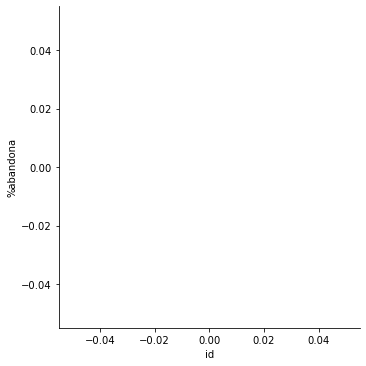

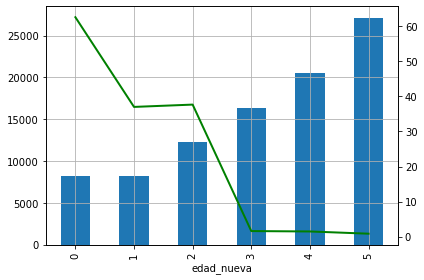

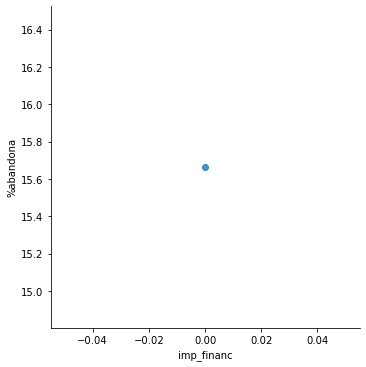

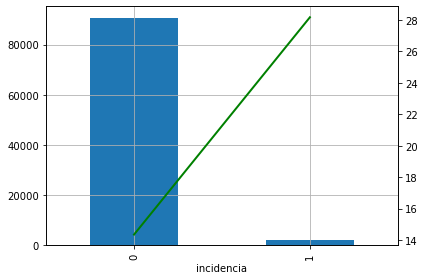

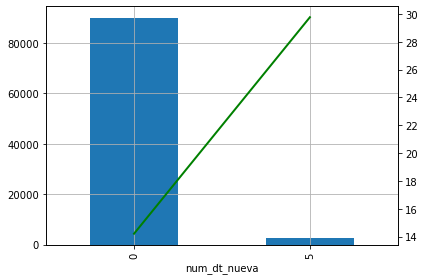

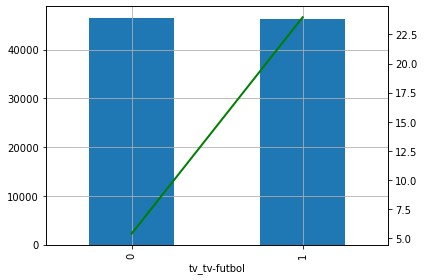

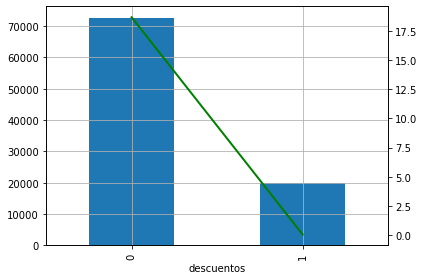

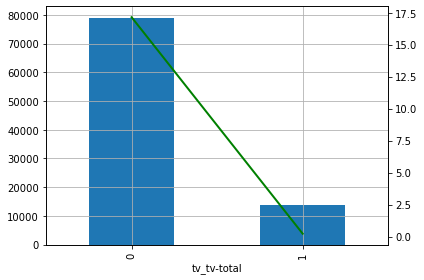

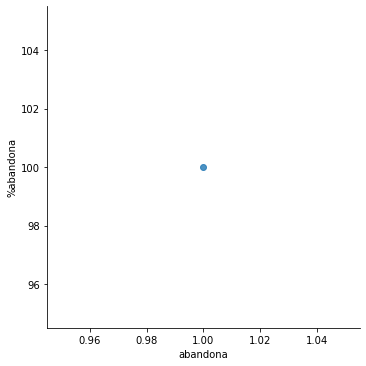

In [351]:
for i in enero_con_predicciones.columns:
    proporciones_final (i, 'abandona', enero_con_predicciones)

In [352]:
# Fórmula modelo
print('logit(abandona) =',intercepto_modelo_ganador[0], ' + ',  coeficientes_modelo_ganador[0][0], '* edad_nueva + ',
      coeficientes_modelo_ganador[0][1], '* imp_financ + ', coeficientes_modelo_ganador[0][2], '* incidencia + ',
      coeficientes_modelo_ganador[0][3], '* num_dt_nueva +', coeficientes_modelo_ganador[0][4], '* tv_tv-futbol +',
      coeficientes_modelo_ganador[0][5], '* descuentos +', coeficientes_modelo_ganador[0][6], '* tv_tv-total')

logit(abandona) = 0.8469442778244831  +  -0.9737947470300596 * edad_nueva +  -0.24426168645212815 * imp_financ +  3.433132238739683 * incidencia +  0.7006397091858954 * num_dt_nueva + 1.4032879710926267 * tv_tv-futbol + -6.69247482664185 * descuentos + -3.331601628250718 * tv_tv-total


#### Interpretación según las variables del modelo. Se seguirá el orden de la fórmula.
##### 
##### Es mucho menos probable que alguien abandone la compañía cuanta más edad tenga. En concreto, a partir de los 50 años, aproximadamente, es complicado que alguien se vaya de la compañía, mientras que los más jóvenes son más propensos a irse.

##### También es menos probable que alguien se vaya de la compañía si tiene alguna terminal financiada. Es más, cuanto más importe pague al mes por esa financiación, más difícil será que abandone la compañía.

##### Es muy probable que el cliente se vaya de la compañía si ha registrado alguna incidencia o reclamación, como es lógico. Es más, esta es la variable que más influye en que un cliente se vaya de la compañía.

##### La variable de número de líneas de impago (num_dt_nueva) influye positivamente en que un cliente se vaya de la compañía. Si el cliente tiene líneas de impago, es más probable que se vaya de la compañía.

##### Cuando un cliente tiene contratado sólo el paquete de fútbol es más probable que se vaya de la compañía que cuando tienen cualquiera de los otros dos paquetes (total o familiar). De hecho, que tengan el paquete total o familiar influye negativamente en que se vaya de la compañía, es decir, serían más propensos a quedarse o a no abandonarla.

##### La variable descuentos es la que más influye en que un cliente no abandone la compañía. Si un cliente tiene descuento, es muy poco probable que se vaya de la compañía.
